In [36]:
import csv
import os
import re
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import simfin as sf
from simfin.names import * 
import seaborn as sns
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import boxcox1p

In [2]:
# get data from simfin
sf.set_data_dir('~/simfin_data/')
companies = sf.load(dataset='companies', market='us')
sector = sf.load(dataset='industries')
share_prices = sf.load_shareprices(variant='daily', market='us')
cash_flow = sf.load_cashflow(variant='quarterly', market='us')
cash_flow_banks = sf.load_cashflow_banks(variant='quarterly', market='us')
cash_flow_insurance = sf.load_cashflow_insurance(variant='quarterly', market='us')
income_statement = sf.load_income(variant='quarterly', market='us')

Dataset "us-companies" on disk (0 days old), loading.
Dataset "industries" on disk (0 days old), loading.
Dataset "us-shareprices-daily" on disk (2 days old), loading.
Dataset "us-cashflow-quarterly" on disk (2 days old), loading.
Dataset "us-cashflow-banks-quarterly" on disk (2 days old), loading.
Dataset "us-cashflow-insurance-quarterly" on disk (2 days old), loading.
Dataset "us-income-quarterly" on disk (0 days old), loading.


In [3]:
# perform share buyback analysis over 2000 stocks
stocks = pd.merge(companies, sector, how='left', on='IndustryId')
share_buybacks = pd.DataFrame(columns = ['Ticker', 'Date', 'Sector', 'BuybackAmount', 'SharesOutstanding', 'AvgPrice'])
index_num = 0
for index, row in stocks.iterrows():
    skipped = False
    if row['Sector'] == 'Financial Services':
        if row['Industry'].split(" ")[0] == 'Insurance':
            try:
                buyback = cash_flow_insurance.loc[row['Ticker']][['Cash (Repurchase) of Equity']]
            except:
                skipped = True
                continue
        else:
            try:
                buyback = cash_flow_banks.loc[row['Ticker']][[CASH_REPURCHASE_EQUITY]]
            except:
                skipped = True
                continue
    else:
        try:
            buyback = cash_flow.loc[row['Ticker']][[CASH_REPURCHASE_EQUITY]]
        except:
            skipped = True
            continue
    buyback = buyback.sort_index()
    
    try:
        shares_outstanding = income_statement.loc[row['Ticker']][[SHARES_DILUTED]]
    except:
        skipped = True
        continue
        
    buyback_shares = pd.merge(buyback, shares_outstanding, on='Report Date')
    
    if skipped == False:
        for index2, row2 in buyback_shares.iterrows():
            # get range in quarterly filing period
            from_date = row2.name
            to_date = row2.name + timedelta(days=89)
            stock_prices = share_prices.loc[row['Ticker']][[SHARE_PRICE]]
            quarter_prices = stock_prices.loc[from_date:to_date]
            # get average stock price in the quarter
            average_price_quarter = quarter_prices['Close'].mean()
            share_buybacks.loc[index_num] = [row['Ticker']] + [row2.name] + [row['Sector']] + \
            [abs(row2['Cash from (Repurchase of) Equity'])] + [row2['Shares (Diluted)']] + \
            [average_price_quarter]
            index_num += 1
        
share_buybacks = share_buybacks.dropna()

In [4]:
# calculate % of company bought back
share_buybacks['%CompanyBought'] = 100*(share_buybacks['BuybackAmount']/(share_buybacks['AvgPrice']*share_buybacks['SharesOutstanding']))

In [24]:
# calculate percent change 
companies_tickers = share_buybacks.Ticker.unique()
final_table = pd.DataFrame()
for company in companies_tickers:
    company_buyback = share_buybacks.loc[share_buybacks['Ticker'] == company]
    company_buyback['%PriceChg'] = 100*(company_buyback.AvgPrice.pct_change())
    final_table = pd.concat([final_table, company_buyback])
final_table = final_table.dropna()
final_table = final_table.loc[(final_table['%CompanyBought'] <= 10.0) &
                             (final_table['%CompanyBought'] >= 0.0) &
                             (final_table['%PriceChg'] >= -100.0) &
                             (final_table['%PriceChg'] <= 100.0)]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
# log transform data 
# final_table['%CompanyBought'] = final_table['%CompanyBought'].apply(lambda x: np.log(x+1))
# final_table['%PriceChg'] = final_table['%PriceChg'].apply(lambda x: np.log(x+1))

In [13]:
print('%PriceChg mean: ' + str("{0:.2f}".format(final_table['%PriceChg'].mean())) + '%')
print('%CompanyBought mean: ' + str("{0:.2f}".format(final_table['%CompanyBought'].mean())) + '%')

%PriceChg mean: 2.75%
%CompanyBought mean: 0.63%


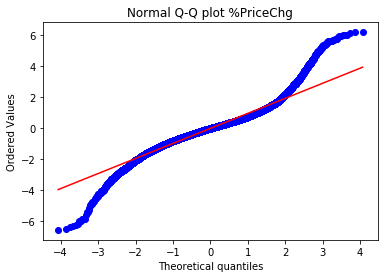

In [14]:
z = (final_table['%PriceChg']-np.mean(final_table['%PriceChg']))/np.std(final_table['%PriceChg'])

stats.probplot(z, dist="norm", plot=plt)
plt.title("Normal Q-Q plot %PriceChg")
plt.show()

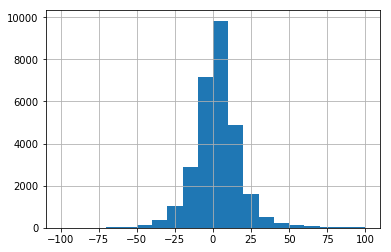

In [20]:
hist = final_table['%PriceChg'].hist(bins=20)

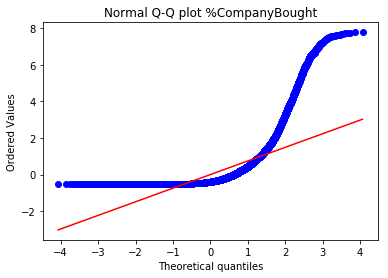

In [25]:
z = (final_table['%CompanyBought']-np.mean(final_table['%CompanyBought']))/np.std(final_table['%CompanyBought'])

stats.probplot(z, dist="norm", plot=plt)
plt.title("Normal Q-Q plot %CompanyBought")
plt.show()

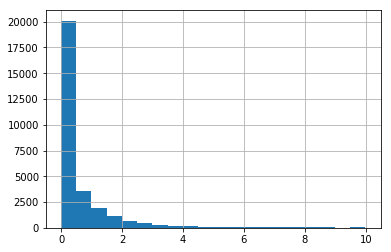

In [58]:
hist = final_table['%CompanyBought'].hist(bins=20)

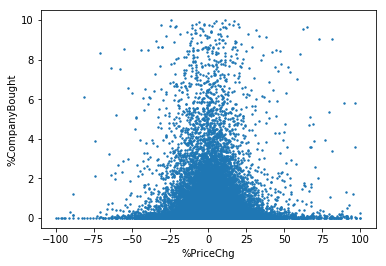

In [16]:
ax = final_table.plot.scatter(x='%PriceChg', y='%CompanyBought', s=2)

In [11]:
final_table.to_csv("share_buybacks.csv", index=False)